In [2]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Enable memory growth if using GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Load the data
df = pd.read_csv('../data/raw/Train.csv')

# Convert Time to datetime with explicit format (day first)
df['Time'] = pd.to_datetime(df['Time'], format='%d-%m-%Y %H:%M')

# Select features (excluding Location and index column)
feature_columns = ['Temp_2m', 'RelHum_2m', 'DP_2m', 'WS_10m', 'WS_100m', 
                   'WD_10m', 'WD_100m', 'WG_10m', 'Power']

# Create feature matrix
data = df[feature_columns].values

# Determine split indices based on the original data length
total_samples = data.shape[0]
train_end = int(0.7 * total_samples)
val_end = train_end + int(0.15 * total_samples)

# Split the data
train_data = data[:train_end]
val_data = data[train_end:val_end]
test_data = data[val_end:]

# Initialize scaler
scaler = StandardScaler()

# Fit the scaler on the training data (excluding the target column)
scaled_train_features = scaler.fit_transform(train_data[:, :-1])

# Transform validation and test data
scaled_val_features = scaler.transform(val_data[:, :-1])
scaled_test_features = scaler.transform(test_data[:, :-1])

# Combine scaled features with the target variable
scaled_train_data = np.column_stack((scaled_train_features, train_data[:, -1]))
scaled_val_data = np.column_stack((scaled_val_features, val_data[:, -1]))
scaled_test_data = np.column_stack((scaled_test_features, test_data[:, -1]))

print("Data shapes after scaling and splitting:")
print(f"Training data shape: {scaled_train_data.shape}")
print(f"Validation data shape: {scaled_val_data.shape}")
print(f"Test data shape: {scaled_test_data.shape}")

Data shapes after scaling and splitting:
Training data shape: (98112, 9)
Validation data shape: (21024, 9)
Test data shape: (21024, 9)


In [4]:
def create_windows(data, window_size=12, target_col=-1):
    """
    Create sliding windows from time series data.
    
    Args:
        data: numpy array of shape (n_samples, n_features)
        window_size: number of time steps to use for input
        target_col: index of target column (default: -1 for last column)
    
    Returns:
        X: numpy array of shape (n_samples - window_size, window_size, n_features)
        y: numpy array of shape (n_samples - window_size,)
    """
    X, y = [], []
    
    for i in range(len(data) - window_size):
        # Get window of all features
        window = data[i:(i + window_size)]
        # Target is the Power value at the next time step
        target = data[i + window_size, target_col]
        
        X.append(window)
        y.append(target)
    
    return np.array(X), np.array(y)

# Create windows for training data
X_train, y_train = create_windows(scaled_train_data, window_size=12)

# Create windows for validation data
X_val, y_val = create_windows(scaled_val_data, window_size=12)

# Create windows for test data
X_test, y_test = create_windows(scaled_test_data, window_size=12)

print("\nWindowed dataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")


Windowed dataset shapes:
X_train: (98100, 12, 9)
y_train: (98100,)
X_val:   (21012, 12, 9)
y_val:   (21012,)
X_test:  (21012, 12, 9)
y_test:  (21012,)


In [6]:
# Create model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    # Output layer (single value prediction)
    Dense(1, activation='sigmoid')  # sigmoid because Power is normalized 0-1
])

# Compile model
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='mse',
    metrics=['mae', 'mse']  # tracking both MAE and MSE
)

# Print model summary
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 108)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


I0000 00:00:1731334477.914685  473316 service.cc:146] XLA service 0x7f0dac0046e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731334477.914715  473316 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-11 14:14:37.926728: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-11 14:14:37.967472: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 200/3066 ━━━━━━━━━━━━━━━━━━━━ 2s 878us/step - loss: 0.0662 - mae: 0.2044 - mse: 0.0660

I0000 00:00:1731334478.450812  473316 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3066/3066 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0331 - mae: 0.1394 - mse: 0.0331 - val_loss: 0.0109 - val_mae: 0.0805 - val_mse: 0.0109
Epoch 2/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0119 - mae: 0.0842 - mse: 0.0119 - val_loss: 0.0067 - val_mae: 0.0630 - val_mse: 0.0067
Epoch 3/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0085 - mae: 0.0705 - mse: 0.0085 - val_loss: 0.0052 - val_mae: 0.0556 - val_mse: 0.0052
Epoch 4/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 980us/step - loss: 0.0068 - mae: 0.0633 - mse: 0.0068 - val_loss: 0.0041 - val_mae: 0.0495 - val_mse: 0.0041
Epoch 5/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step - loss: 0.0058 - mae: 0.0583 - mse: 0.0058 - val_loss: 0.0035 - val_mae: 0.0457 - val_mse: 0.0035
Epoch 6/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0052 - mae: 0.0548 - mse: 0.0052 - val_loss: 0.0031 - val_mae: 0.0430 - val_mse: 0.0031
Epoch 7/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 997us/step - loss: 0.0047 - mae: 0.0522 - ms

Evaluating the model

In [ ]:
# Create a unique directory for the results based on the current timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_dir = f'../results/sgd_run_{timestamp}'
os.makedirs(results_dir, exist_ok=True)

# Evaluate on validation set
val_predictions = model.predict(X_val)
r2_val = r2_score(y_val, val_predictions)
mse_val = mean_squared_error(y_val, val_predictions)
mae_val = mean_absolute_error(y_val, val_predictions)
print(f"\nValidation R² score: {r2_val:.4f}")
print(f"Validation MSE: {mse_val:.6f}")
print(f"Validation MAE: {mae_val:.6f}")

# Print best validation metrics from training history
best_epoch = np.argmin(history.history['val_loss'])
print(f"\nBest validation results (epoch {best_epoch + 1}):")
print(f"MSE: {history.history['val_mse'][best_epoch]:.6f}")
print(f"MAE: {history.history['val_mae'][best_epoch]:.6f}")

# Evaluate on test set
test_predictions = model.predict(X_test)
r2_test = r2_score(y_test, test_predictions)
mse_test = mean_squared_error(y_test, test_predictions)
mae_test = mean_absolute_error(y_test, test_predictions)
print(f"\nTest R² score: {r2_test:.4f}")
print(f"Test MSE: {mse_test:.6f}")
print(f"Test MAE: {mae_test:.6f}")

# Save evaluation metrics
evaluation_metrics = {
    'validation_r2_score': float(r2_val),
    'validation_mse': float(mse_val),
    'validation_mae': float(mae_val),
    'test_r2_score': float(r2_test),
    'test_mse': float(mse_test),
    'test_mae': float(mae_test),
    'best_epoch': int(best_epoch + 1),
    'best_val_loss': float(history.history['val_loss'][best_epoch]),
    'best_val_mse': float(history.history['val_mse'][best_epoch]),
    'best_val_mae': float(history.history['val_mae'][best_epoch]),
}

evaluation_metrics_path = os.path.join(results_dir, 'evaluation_metrics.json')
with open(evaluation_metrics_path, 'w') as f:
    json.dump(evaluation_metrics, f, indent=4)

657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step

Validation R² score: 0.9843
Validation MSE: 0.000780
Validation MAE: 0.020577

Best validation results (epoch 86):
MSE: 0.000780
MAE: 0.020577
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step

Test R² score: 0.9867
Test MSE: 0.000715
Test MAE: 0.019589


Visualizations

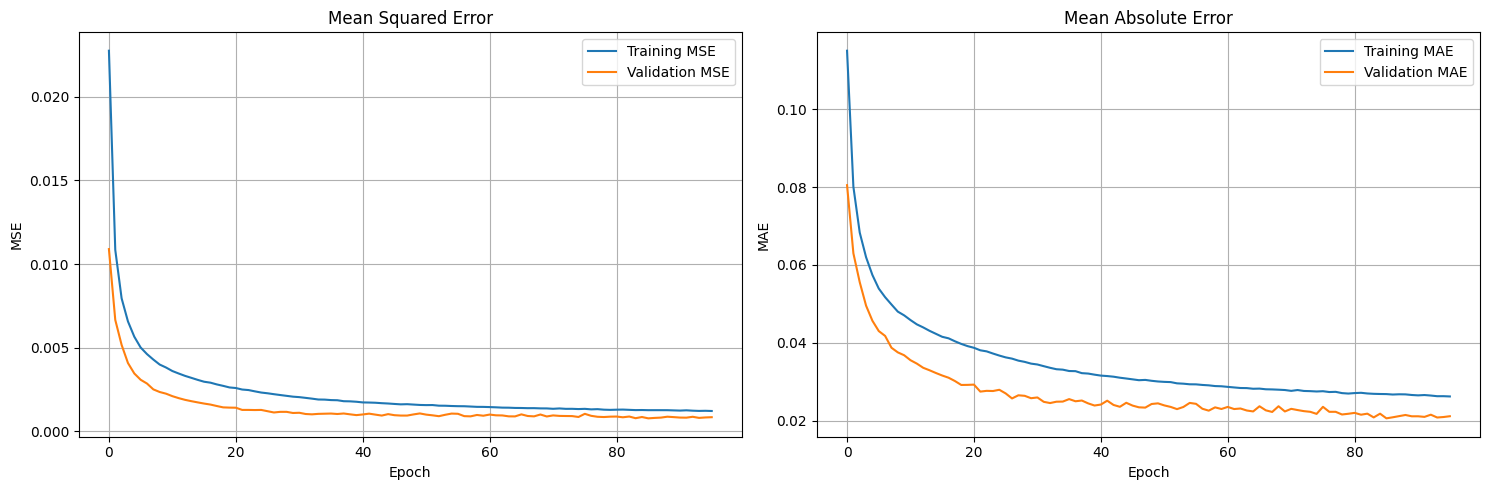

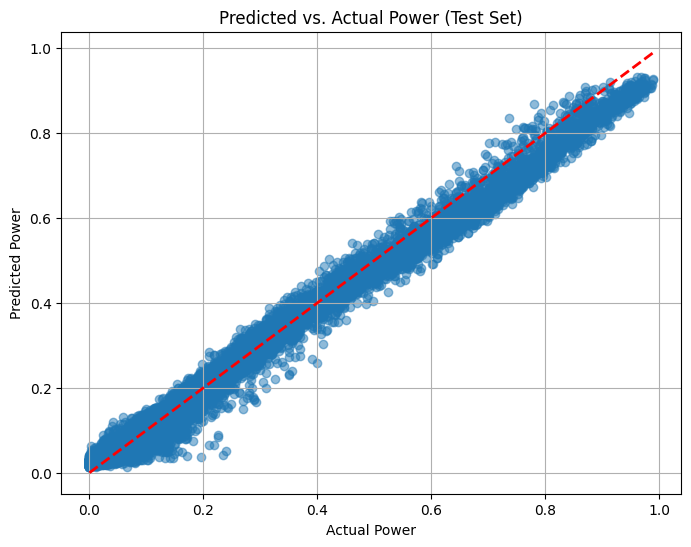

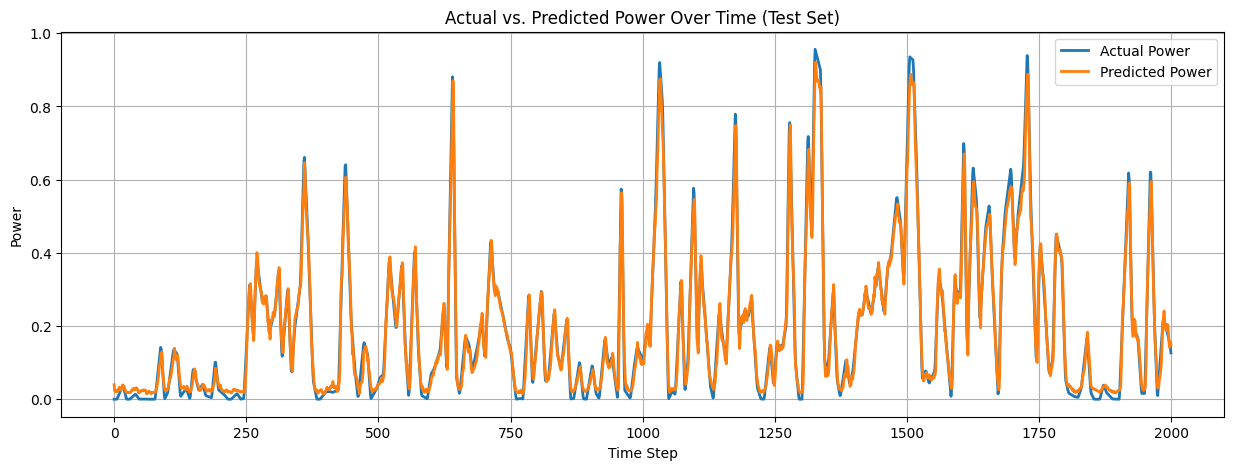

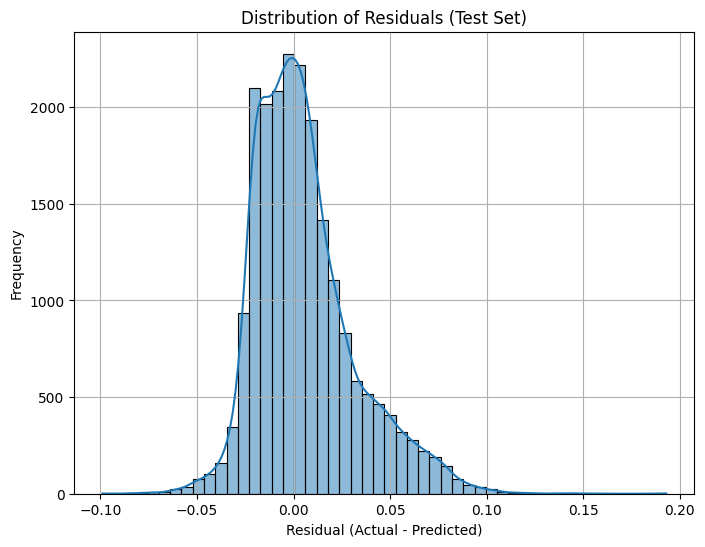

In [9]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot MSE
ax1.plot(history.history['mse'], label='Training MSE')
ax1.plot(history.history['val_mse'], label='Validation MSE')
ax1.set_title('Mean Squared Error')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')
ax1.legend()
ax1.grid(True)

# Plot MAE
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title('Mean Absolute Error')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Save the training history plot
training_history_plot_path = os.path.join(results_dir, 'training_history.png')
fig.savefig(training_history_plot_path)

# Visualizations using the Test Set

## Scatter Plot: Predicted vs. Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Power')
plt.ylabel('Predicted Power')
plt.title('Predicted vs. Actual Power (Test Set)')
plt.grid(True)
scatter_plot_path = os.path.join(results_dir, 'predicted_vs_actual_scatter.png')
plt.savefig(scatter_plot_path)
plt.show()

## Line Chart: Actual vs. Predicted Values Over Time
# Select a small continuous portion of the data
start_idx = 0  # Adjust as needed
end_idx = start_idx + 2000

plt.figure(figsize=(15, 5))
plt.plot(range(start_idx, end_idx), y_test[start_idx:end_idx], label='Actual Power', linewidth=2)
plt.plot(range(start_idx, end_idx), test_predictions[start_idx:end_idx], label='Predicted Power', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Power')
plt.title('Actual vs. Predicted Power Over Time (Test Set)')
plt.legend()
plt.grid(True)
line_chart_path = os.path.join(results_dir, 'actual_vs_predicted_over_time.png')
plt.savefig(line_chart_path)
plt.show()

## Distribution of Residuals
residuals = y_test - test_predictions.squeeze()
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Test Set)')
plt.grid(True)
residuals_plot_path = os.path.join(results_dir, 'residuals_distribution.png')
plt.savefig(residuals_plot_path)
plt.show()

In [10]:
# 1. Save Model Weights and Architecture

## Save the model weights
model_weights_path = os.path.join(results_dir, 'model.weights.h5')
model.save_weights(model_weights_path)

## Save the model architecture to JSON
model_json = model.to_json()
model_architecture_path = os.path.join(results_dir, 'model_architecture.json')
with open(model_architecture_path, 'w') as json_file:
    json_file.write(model_json)

# 2. Save Training Parameters and History

## Save training parameters (hyperparameters)
training_params = {
    'optimizer': 'SGD',
    'learning_rate': 0.01,
    'momentum': 0.9,
    'loss_function': 'mse',
    'batch_size': 32,
    'epochs': len(history.history['loss']),
    'window_size': 12,
    'n_timesteps': n_timesteps,
    'n_features': n_features,
    'early_stopping_patience': 10,
    'train_size': X_train.shape[0],
    'validation_size': X_val.shape[0],
    'test_size': X_test.shape[0],
    'random_seed': 42,
}

training_params_path = os.path.join(results_dir, 'training_params.json')
with open(training_params_path, 'w') as f:
    json.dump(training_params, f, indent=4)

## Save training history
training_history_path = os.path.join(results_dir, 'training_history.json')
with open(training_history_path, 'w') as f:
    json.dump(history.history, f, indent=4)

# 3. Save Scaler Object

## Save the scaler used for data preprocessing
scaler_path = os.path.join(results_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)

# 4. Save Model Summary

## Capture the model summary to a text file
model_summary_path = os.path.join(results_dir, 'model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# 5. Notify Completion and Results Directory
print(f"\nAll results have been saved to the directory: {results_dir}")


All results have been saved to the directory: ../results/run_20241111_141927
